### Testing of the code during development

Looking at the M1-1 dataset

In [1]:
import os
import glob
from oyv.imports import *
import importlib

playsound is relying on another python subprocess. Please use `pip install pygobject` if you want playsound to run more efficiently.


In [2]:
%matplotlib inline

In [3]:
# Load the modules
os.chdir('../../')
from sigpyproc import sig_funcs, sig_append_external
os.chdir('testing/development/')

### Load data from M1-1


In [4]:
floc = '/media/oyvindl/ratatosk/data/mooring_data/signature500/m1_1/converted/*'
flist = glob.glob(floc)
for fn in flist:
    if '_avgd' in fn:
        flist.remove(fn)

In [5]:
DX = sig_funcs.matfiles_to_dataset(flist, )

/home/oyvindl/work/code/git_public/sigpyproc/sigpyproc/sig_funcs.py:505: RuntimeWarning: invalid value encountered in sqrt
  180 / np.pi* np.arccos(np.sqrt(
/home/oyvindl/work/code/git_public/sigpyproc/sigpyproc/sig_funcs.py:514: RuntimeWarning: invalid value encountered in sqrt
  180 / np.pi* np.arccos(np.sqrt(


1870992 time points, 38979 ensembles. Sample per ensemble: 48
Done. Run sig_funcs.overview() to print some additional details.


In [10]:
## Print some stuff with the overview() function
sig_funcs.overview(DX)


TIME RANGE:
06 Oct 2018 12:00  -->  16 Nov 2019 12:30  (406.0 days)
Time between ensembles: 15.0 min.
Time between samples in ensembles: 1.0 sec.

PRESSURE:
Median (STD) of altimeter pressure: 20.6 dbar (0.5 dbar)  - with fixed atm offset 9.500 dbar.

SIZE:
Total 1870992 time points.
Split into 38979 ensembles with 48 sample per ensemble.
Ocean velocity bins: 16.


### Look at FOM

Show the 

In [7]:
from sklearn.metrics import confusion_matrix

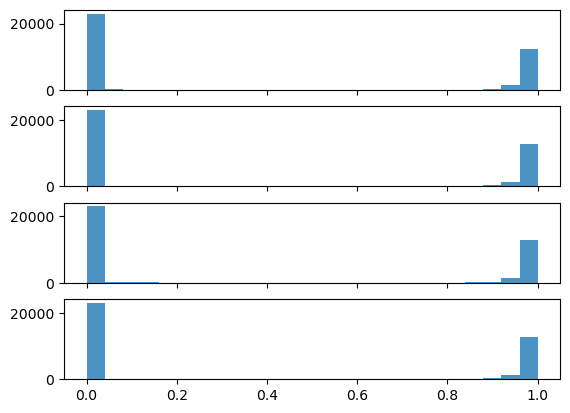

In [22]:
fig, ax = plt.subplots(4, 1, sharex = True, sharey = True)
MEAN_FOM = np.zeros([4, DX.dims['TIME']])
for nn in np.arange(1, 5):
    nm = 'AverageIce_FOMBeam%i'%nn
    mean_FOM = DX[nm].mean(axis = 1)
    ax[nn-1].hist(mean_FOM/ mean_FOM.max(), 25, alpha = 0.8, )
    MEAN_FOM[nn-1, :] = mean_FOM

### Print a matrix showing how often the individual beams agree

In [25]:
ice_BINARY = MEAN_FOM > 10000

agreement_matrix = np.zeros((4, 4))

for nn in np.arange(1, 5):
    for mm in np.arange(1, 5):
        agree_nn_mm = np.mean(ice_BINARY[nn-1]==ice_BINARY[mm-1])
        agreement_matrix[nn-1, mm-1] = np.round(agree_nn_mm, 3)
print(agreement_matrix)

[[1.    0.97  0.969 0.97 ]
 [0.97  1.    0.971 0.967]
 [0.969 0.971 1.    0.969]
 [0.97  0.967 0.969 1.   ]]


In [14]:
agreement_matrix

array([[1., 1., 1., 1.],
       [1., 1., 1., 1.],
       [1., 1., 1., 1.],
       [1., 1., 1., 1.]])

In [62]:
### Function for classifying (OCEAN, [all_ice, some_ice] <- ICE)

def ice_class_FOM(DX, ice_thr = 10000):
    
    
    # Unambiguously open water: 
    # NO FOM above the threshold in ANY sample in ANY beam 
    is_ow = np.bool_(np.ones(DX.dims['TIME']))
    for nn in np.arange(1, 5):
        FOMnm = 'AverageIce_FOMBeam%i'%nn
        is_ow *= DX[FOMnm].min(axis = 1) > ice_thr

    
    # Unambiguously ice: 
    # NO FOM bwlow the threshold in ANY sample in ANY beam 
    is_ice = np.bool_(np.ones(DX.dims['TIME']))
    for nn in np.arange(1, 5):
        FOMnm = 'AverageIce_FOMBeam%i'%nn
        is_ice *= DX[FOMnm].max(axis = 1) < ice_thr 
        
    ice_class_num = np.ones(DX.dims['TIME'])
    ice_class_num[is_ow] = 0
    ice_class_num[is_ice] = 2

    return is_ow, is_ice, ice_class_num

In [ ]:
DX:

In [84]:
    IS_ICE_SAMPLE = np.bool_(np.ones([DX.dims['TIME'], DX.dims['SAMPLE']]))


In [126]:
def SIC_FOM(DX, ice_thr = 10000):
    
    IS_ICE_SAMPLE = np.bool_(np.ones([DX.dims['TIME'], DX.dims['SAMPLE']]))
    
    for nn in np.arange(1, 5):
        FOMnm = 'AverageIce_FOMBeam%i'%nn
        IS_ICE_SAMPLE *= DX[FOMnm] < ice_thr

    SIC = IS_ICE_SAMPLE.mean(axis = 1)*100
    return SIC

In [115]:
sic_fom = SIC_FOM(DX)

In [116]:
sic_fom

<xarray.DataArray 'AverageIce_FOMBeam1' (TIME: 38979)>
array([0., 0., 0., ..., 0., 0., 0.])
Coordinates:
  * TIME     (TIME) float64 1.781e+04 1.781e+04 ... 1.822e+04 1.822e+04

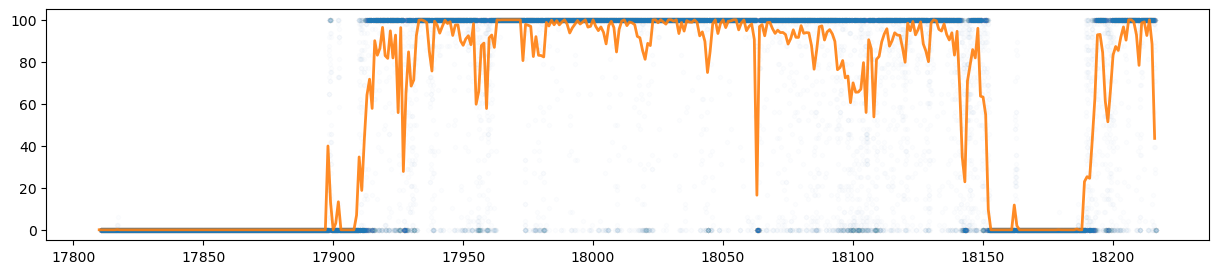

In [125]:
fig, ax = plt.subplots(figsize = (15, 3))
ax.plot( DX.TIME, sic_fom, '.', alpha = 0.01)
SIC_daily, t_daily = stats.dmean(sic_fom, DX.TIME)
ax.plot(t_daily, SIC_daily, '-', alpha = 0.9, lw = 2)

12.98 % of the ensembles are unambiguously open water
54.81 % of the ensembles are unambiguously ice
32.20 % of the ensembles probably have some ice


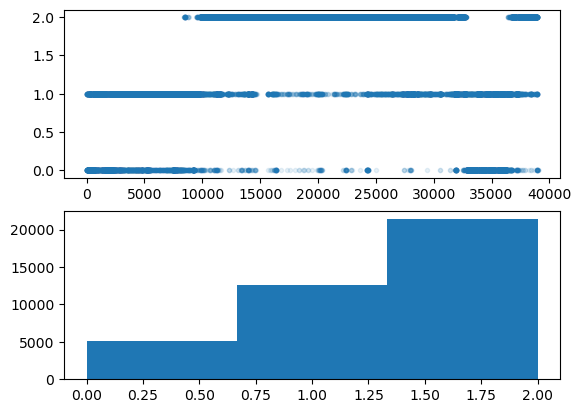

In [127]:
is_ow, is_ice, ice_class_num = ice_class_FOM(DX)

fig, ax = plt.subplots(2, 1)
ax[0].plot(ice_class_num, '.', alpha = 0.1)
ax[1].hist(ice_class_num, 3,)

frac_ow = np.mean(is_ow)
frac_ice = np.mean(is_ice)

print('%.2f %% of the ensembles are unambiguously open water'%(frac_ow*100))
print('%.2f %% of the ensembles are unambiguously ice'%(frac_ice*100))
print('%.2f %% of the ensembles probably have some ice'%((1-frac_ice-frac_ow)*100))

(array([     0.,      0.,      0.,      0.,      0.,      0.,      0.,
             0.,      0.,      0.,      0.,      0.,      0.,      0.,
             0.,      0.,      0.,      0.,      0.,      0.,      0.,
             0.,      0.,      0.,      0.,      0.,      0.,      0.,
             0.,      0.,      0.,      0.,      0.,      0.,      0.,
             0.,      0.,      0.,      0.,      0.,      0.,      0.,
             0.,      0.,      0.,      0.,      0.,      0.,      0.,
             0.,      0.,      0.,      0.,      0.,      0., 713942.,
             0.,      0.,      0.,      0.,      0.,      0.,      0.,
             0.,      0.,      0.,      0.,      0.,      0.,      0.,
             0.,      0.,      0.,      0.,      0.,      0.,      0.,
             0.,      0.,      0.,      0.,      0.,      0.,      0.,
             0.,      0.,      0.,      0.,      0.,      0.,      0.,
             0.,      0.,      0.,      0.,      0.,      0.,      0.,
      

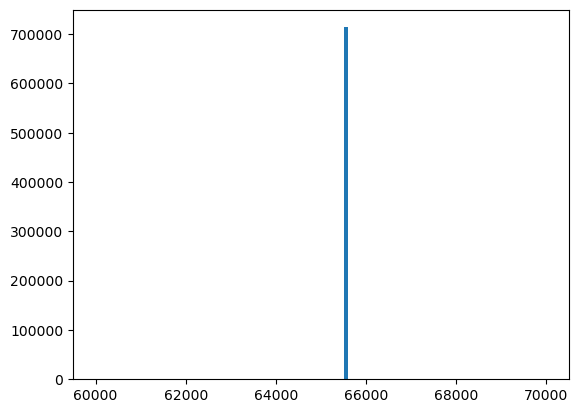

In [82]:
fig, ax = plt.subplots()
ax.plot()

In [130]:
hasattr(DX, 'TIME')

True

In [135]:
DX.Average_AltimeterDistanceAST

<xarray.DataArray 'Average_AltimeterDistanceAST' (TIME: 38979, SAMPLE: 48)>
array([[20.302954  , 19.976751  , 20.88669   , ..., 20.559713  ,
        20.234442  , 20.470144  ],
       [20.305473  , 20.24968   , 20.55375   , ..., 20.718475  ,
        20.367237  , 19.898516  ],
       [21.45017   , 20.672514  , 20.015337  , ..., 20.71852   ,
        20.08733   , 20.251133  ],
       ...,
       [ 0.5513362 ,  0.55310076,  0.55430025, ...,  0.5546465 ,
         0.55070555,  0.55858815],
       [ 0.5527211 ,  0.5442152 ,  0.5442306 , ...,  0.54832923,
         0.5507394 ,  0.5452383 ],
       [ 0.54580766,  0.546404  ,  0.5489835 , ...,  0.5436946 ,
         0.543467  ,  0.5442937 ]], dtype=float32)
Coordinates:
  * TIME     (TIME) float64 1.781e+04 1.781e+04 ... 1.822e+04 1.822e+04
  * SAMPLE   (SAMPLE) int64 1 2 3 4 5 6 7 8 9 10 ... 40 41 42 43 44 45 46 47 48

In [137]:
def get_draft(DX, ow_corr):
    
    if hasattr(DX, 'sound_speed'):
        ss_factor = DX.sound_speed/DX.Average_Soundspeed
    else:
        ss_factor = 1
    
    if hasattr(DX, 'corrected_depth'):
        dep = DX.corrected_depth
    else:
        raise Warning('Compute draft without atmospheric correction - careful!')
        dep = DX.uncorrected_depth

    if not ow_corr:
        ow_corr = 1
        
    draft = (dep - ss_factor*ow_corr*np.cos(DX.tilt*np.pi/180)
                      *DX.Average_AltimeterDistanceAST)
        
    return draft